# Unbiased Teacher for custom dataset


This notebook is intened as an example for custom dateset with no annotations for the unlabelled images.


**Instructions**

1.   Register dataset.

To do so, add the following code to train_net.py:

```
from detectron2.data.datasets import register_coco_instances

register_coco_instances("***YOR DATASET NAME***", {}, "***PATH TO ANNOTATION JSON FILE***", "***PATH TO IMG FOLDER***")
```

Do so for both training and validation datasets. Training dataset should include both labeled and unlabeled images.

Replace this code in `unbiased-teacher/ubteacher/data/build.py`:
```
# read from pre-generated data seed
    with open(random_data_seed_path) as COCO_sup_file:
        coco_random_idx = json.load(COCO_sup_file)

labeled_idx = np.array(coco_random_idx[str(SupPercent)][str(random_data_seed)])
```
With:
`labeled_idx = np.array([i for i in range(1, num_label+1)])`

Please note that in order for this code to work labelled images must come first in your custom dataset. If you do not know how to do that:

Load both labelled and unlabelled images in an annotation softer that can export COCO format annotations (e.g CVAT). Make sure that labelled images are loaded first. Export tham in COCO format.

2.   Create a config file with your dataset and number of classes:

```
DATASETS:
  CROSS_DATASET: False
  TRAIN: ("***YOR TRAIN DATASET NAME***",)
  TEST: ("***YOR TEST DATASET NAME***",)
```
```
 ROI_HEADS:
    NAME: "StandardROIHeadsPseudoLab"
    LOSS: "FocalLoss"
    NUM_CLASSES: 1
```
A good idea would be to make a copy of `unbiased-teacher/configs/coco_supervision/faster_rcnn_R_50_FPN_sup1_run1.yaml` and replace it with your required parameters. The ones mentioned above are the ones that are required, feel fre to change others aswell.



## 0. Setup

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %cd /content/gdrive/MyDrive
# !git clone https://github.com/facebookresearch/unbiased-teacher

# %cd /content/gdrive/MyDrive/unbiased-teacher
# !mkdir datasets

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-txlyayhm
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-txlyayhm
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 147 kB 28.5 MB/s 
     |████████████████████████████████| 130 kB 72.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 843 kB 61.9 MB/s 
     |████████████████████████████████| 749 kB 63.1 MB/s 
     |████████████████████████████████| 596 kB 67.3 MB/s 
     |████████████████████████████████| 112 kB 77.5 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5301439 sha256=f7aa5d5b307503be2b4e01c537439920e7c990b5ab8a84f6c6b2a7192ceeb76b
  Stored in directory: /tmp/pip-ephem-wheel-cache-22_2l1hm/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [ ]:
# %cd /content/gdrive/MyDrive/detectron2
# !pip install -e .

In [ ]:
# %cd /content/gdrive/MyDrive/unbiased-teacher/datasets
# !ln -s /content/gdrive/MyDrive/data/coco weeds

## 1. Training

**BASE:**

In [ ]:
%%bash
cd /content/gdrive/MyDrive/unbiased-teacher
python train_net.py \
      --num-gpus 1 \
      --config configs/coco_supervision/weeds_base.yaml

**SSL:**

In [ ]:
%%bash
cd /content/gdrive/MyDrive/unbiased-teacher
python train_net.py \
      --num-gpus 1 \
      --config configs/coco_supervision/weeds_ssl.yaml \
      DATALOADER.SUP_PERCENT 9.1

**RESUME:**

In [ ]:
%%bash
cd /content/gdrive/MyDrive/unbiased-teacher
python train_net.py \
      --resume \
      --num-gpus 1 \
      --config configs/coco_supervision/weeds_ssl.yaml \
       DATALOADER.SUP_PERCENT 9.1 MODEL.WEIGHTS /content/gdrive/MyDrive/unbiased-teacher/output/model_final.pth

**ZIP OUTPUT:**

In [ ]:
!zip -r /content/gdrive/MyDrive/x10.zip /content/gdrive/MyDrive/unbiased-teacher/output

## 2. Eval

In [8]:
%%bash
cd /content/gdrive/MyDrive/unbiased-teacher
python train_net.py \
      --eval-only \
      --num-gpus 1 \
      --config /content/gdrive/MyDrive/unbiased-teacher/configs/coco_supervision/weeds_ssl.yaml \
      MODEL.WEIGHTS /content/gdrive/MyDrive/unbiased-teacher/output/model_best.pth

Command Line Args: Namespace(config_file='/content/gdrive/MyDrive/unbiased-teacher/configs/coco_supervision/weeds_ssl.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=True, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', '/content/gdrive/MyDrive/unbiased-teacher/output/model_best.pth'], resume=False)
[04/26 16:40:29 detectron2]: Rank of current process: 0. World size: 1
[04/26 16:40:30 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------
sys.platform            linux
Python                  3.7.13 (default, Apr 24 2022, 01:04:09) [GCC 7.5.0]
numpy                   1.21.6
detectron2              0.6 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.5
CUDA compiler           CUDA 11.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.11.0+cu113 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     False
GPU available

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 3. Inference

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("weeds_train_base", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_train_base.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/train_base")
register_coco_instances("weeds_train_x1", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_train_x1.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/train_x1")
register_coco_instances("weeds_train_x2", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_train_x2.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/train_x2")
register_coco_instances("weeds_train_x5", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_train_x5.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/train_x5")
register_coco_instances("weeds_train_x10", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_train_x10.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/train_x10")
register_coco_instances("weeds_val", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_val.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/val")
register_coco_instances("weeds_test", {}, "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/annotations/instances_test.json", "/content/gdrive/MyDrive/unbiased-teacher/datasets/weeds/test")

In [8]:
from detectron2.config import get_cfg

cfg = get_cfg()

cfg.merge_from_file("/content/gdrive/MyDrive/unbiased-teacher/configs/Base-RCNN-FPN.yaml")
cfg.MODEL.WEIGHTS = os.path.join("/content/gdrive/MyDrive/unbiased-teacher/output/model_best.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50   # set the testing threshold for this model
cfg.DATASETS.TRAIN = ("weeds_train_x10", )
cfg.DATASETS.TEST = ("weeds_test", )

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


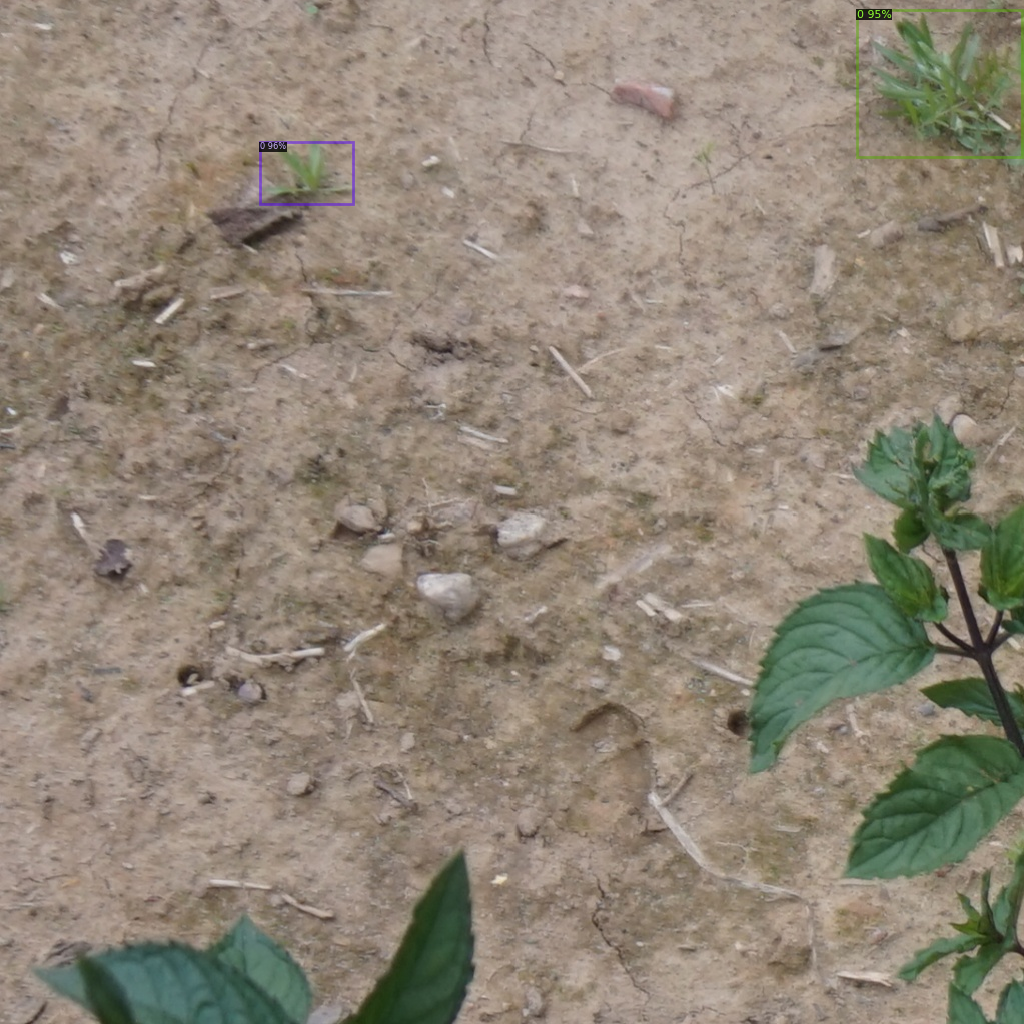

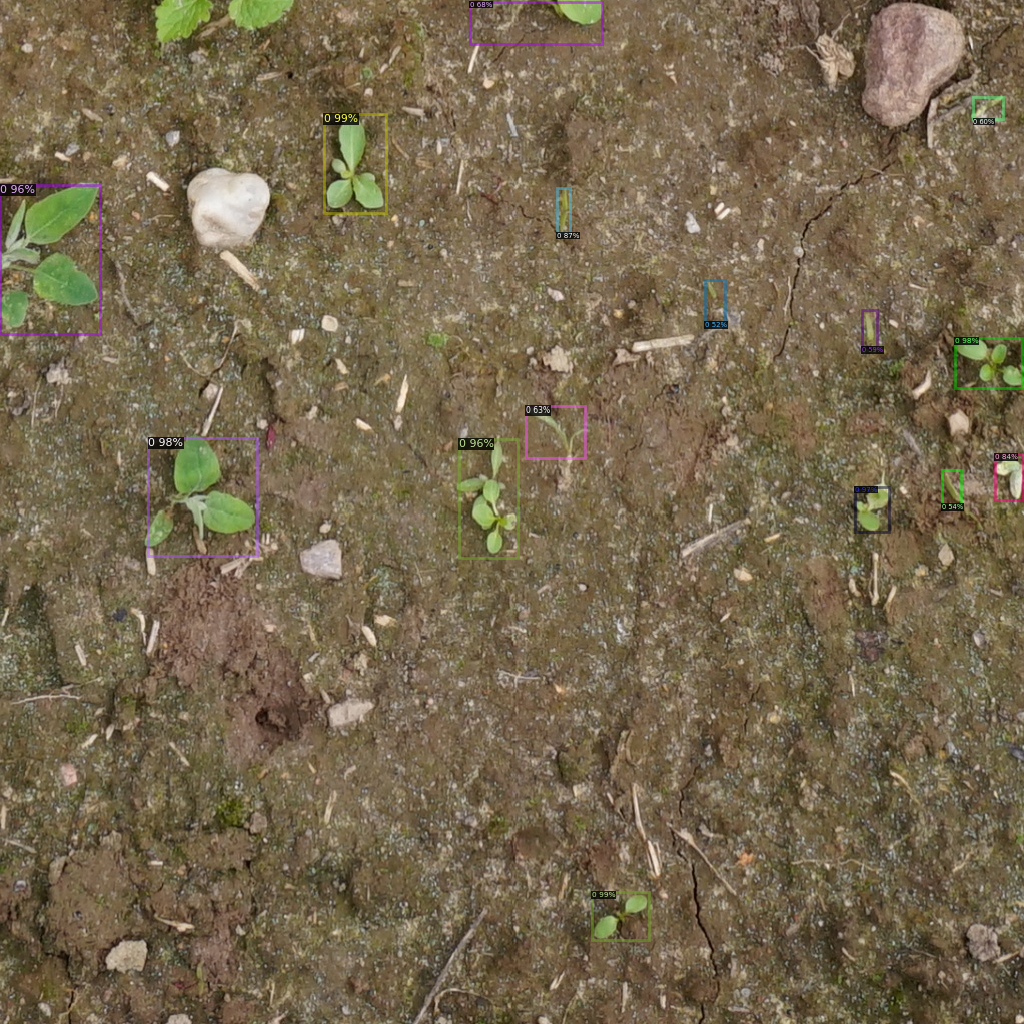

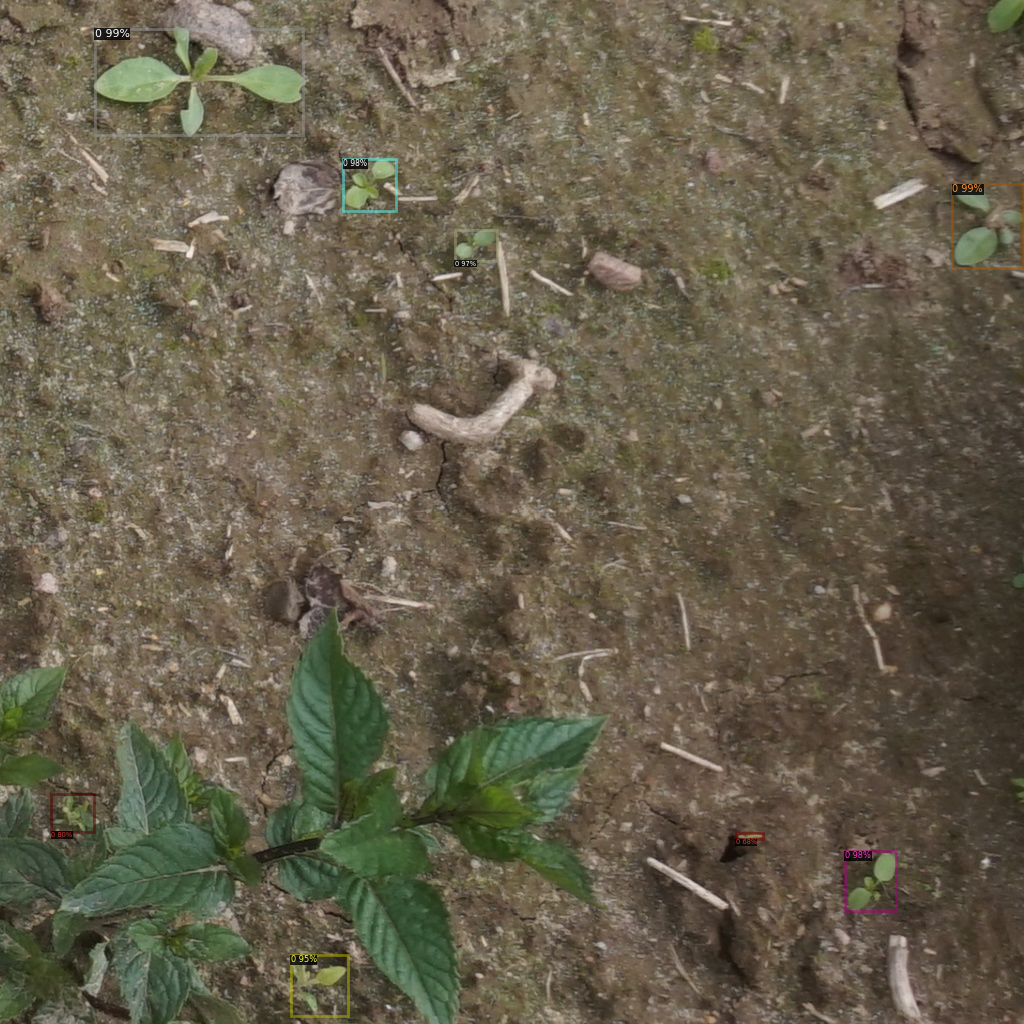

In [9]:
%cd /content/gdrive/MyDrive/unbiased-teacher

from detectron2.data import DatasetCatalog
import cv2, random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
from ubteacher.engine.trainer import CustomPredictor

dataset_dicts = DatasetCatalog.get("weeds_test")
predictor = CustomPredictor(cfg)

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   scale=1
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])